# Introduction

## Importing an audio file with Python

In [35]:
import wave
import pandas as pd
import numpy as np
from pydub import AudioSegment
from pydub.playback import play  # requires simpleaudio (WAV) or ffmpeg (others)

In [ ]:
training_labels = pd.read_csv("data/raw/training_label.csv")

folder = "data/raw/Training_data"
file = f"{folder}/1.wav"

In [65]:
training_labels 

nombre_archivo  clase
0            1.wav      1
1            2.wav      1
2            3.wav      1
3            4.wav      1
4            5.wav      1
..             ...    ...
126        178.wav      5
127        179.wav      5
128        180.wav      5
129        181.wav      5
130        182.wav      5

[131 rows x 2 columns]

In [63]:
# plot the normalized audio file
import matplotlib.pyplot as plt
def plot_waveform(signal, title="Waveform", xlabel="Time", ylabel="Amplitude"):
    plt.figure(figsize=(15, 5))
    plt.plot(signal)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    

In [ ]:
training_labels = pd.read_csv("data/raw/training_label.csv")

folder = "data/raw/Training_data"
file = f"{folder}/1.wav"

seg = AudioSegment.from_file(file)  # works out of the box for WAV
# 2) Inspect core parameters
print({
    "channels": seg.channels,
    "frame_rate": seg.frame_rate,      # Hz
    "sample_width": seg.sample_width,  # bytes per sample. A byte per sample means that each sample is an integer between 0 and 255
    "duration_ms": len(seg),           # milliseconds
    "max_amplitude": seg.max           # max possible amplitude the range is 0 to (2^(8*sample_width))-1
})
# 3) Normalize to ASR-friendly PCM: mono, 16 kHz, 16-bit
target = (
    seg.set_channels(1)
       .set_frame_rate(100)
       .set_sample_width(1)  # 2 bytes = 16-bit PCM
)


plot_waveform(target.get_array_of_samples())

{'channels': 2, 'frame_rate': 44100, 'sample_width': 2, 'duration_ms': 225050, 'max_amplitude': 16883}


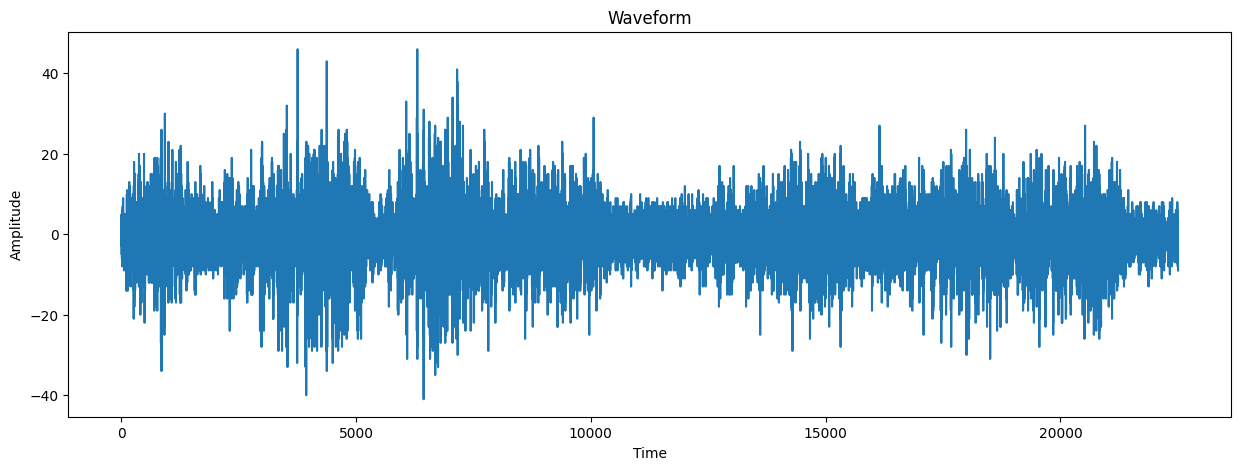

In [ ]:
training_labels = pd.read_csv("data/raw/training_label.csv")

folder = "data/raw/Training_data"
file = f"{folder}/1.wav"

seg = AudioSegment.from_file(file)  # works out of the box for WAV
# 2) Inspect core parameters
print({
    "channels": seg.channels,
    "frame_rate": seg.frame_rate,      # Hz
    "sample_width": seg.sample_width,  # bytes per sample. A byte per sample means that each sample is an integer between 0 and 255
    "duration_ms": len(seg),           # milliseconds
    "max_amplitude": seg.max           # max possible amplitude the range is 0 to (2^(8*sample_width))-1
})
# 3) Normalize to ASR-friendly PCM: mono, 16 kHz, 16-bit
target = (
    seg.set_channels(1)
       .set_frame_rate(100)
       .set_sample_width(1)  # 2 bytes = 16-bit PCM
)


plot_waveform(target.get_array_of_samples())

C:\Users\herie\AppData\Local\Temp\ipykernel_12060\2024664255.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


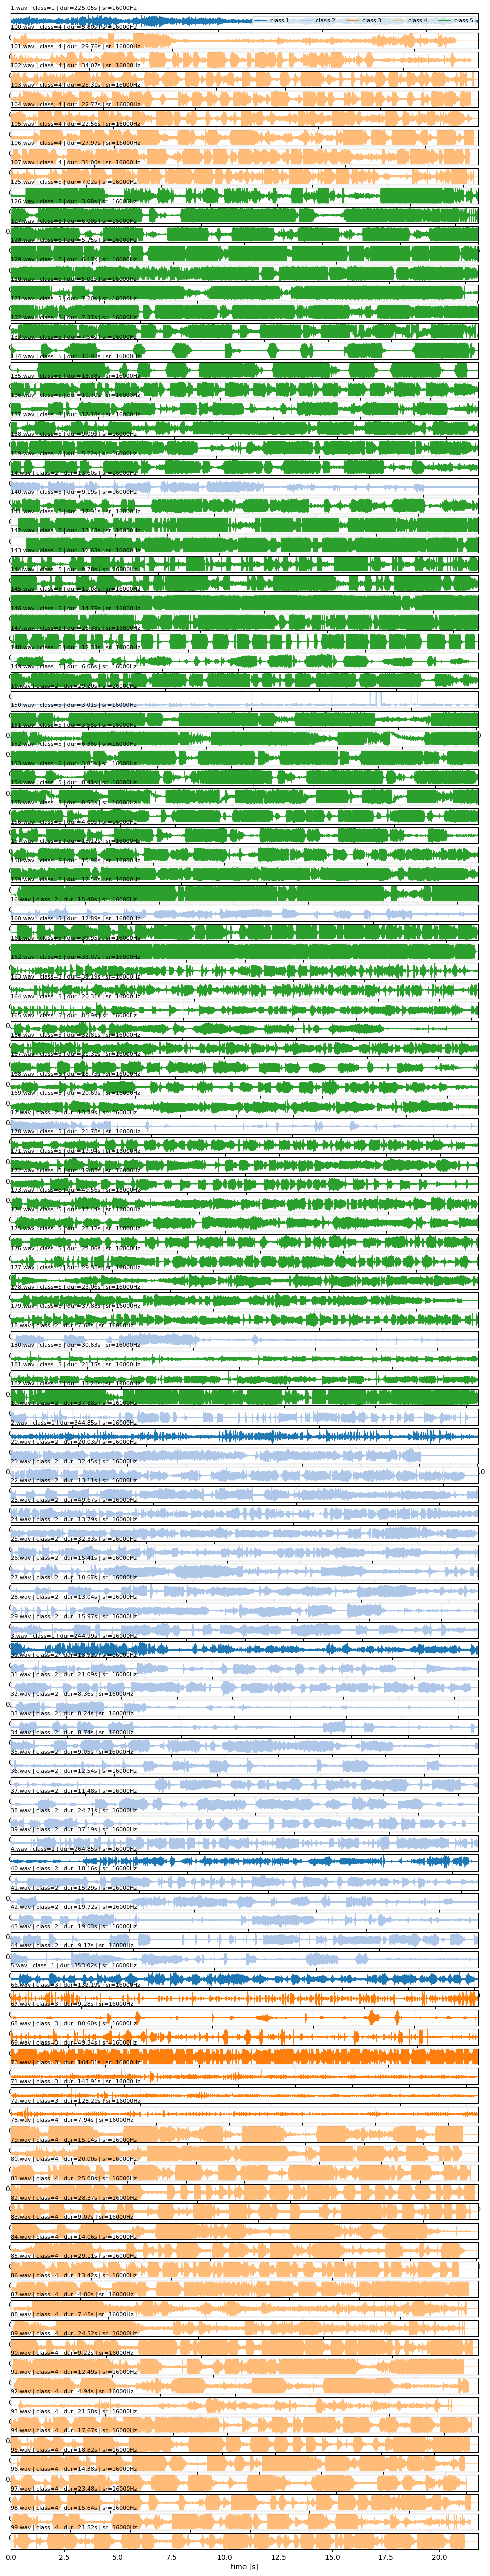

In [67]:
# %pip install -U pandas matplotlib pydub

import os, glob, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pydub import AudioSegment

# -----------------------------
# CONFIG
# -----------------------------
CSV_PATH   = "data/raw/training_label.csv"
AUDIO_DIR  = Path("data/raw/Training_data")
PATTERN    = "*.wav"
MAX_FILES  = None              # e.g. 120 to limit; None = all
TARGET_SR  = 16_000            # None = keep original; else resample with pydub
TARGET_SW  = 2                 # bytes per sample; 2 = 16-bit PCM
MAKE_MONO  = True              # force mono for consistent plots
DOWNSAMPLE = 4                 # plot every k-th point; set 1 for full resolution
SAVE_PNG   = None              # e.g. "results/all_waveforms_pydub.png"

# -----------------------------
# HELPERS
# -----------------------------
def segment_to_mono_np(seg: AudioSegment) -> tuple[np.ndarray, float]:
    """
    Convert a pydub AudioSegment to a normalized mono numpy array in [-1, 1),
    and return (y, sr). Handles sample width and sign.
    """
    sw = seg.sample_width
    sr = float(seg.frame_rate)
    if MAKE_MONO and seg.channels != 1:
        seg = seg.set_channels(1)
    if TARGET_SR is not None and seg.frame_rate != TARGET_SR:
        seg = seg.set_frame_rate(TARGET_SR)
        sr = float(TARGET_SR)
    if TARGET_SW is not None and seg.sample_width != TARGET_SW:
        seg = seg.set_sample_width(TARGET_SW)
        sw = TARGET_SW

    arr = np.array(seg.get_array_of_samples())

    # Normalize by signed peak based on sample width
    # 8-bit: peak = 2^(8-1) = 128; 16-bit: 32768; 24-bit: 8388608; 32-bit: 2147483648
    peak = float(1 << (8 * sw - 1))
    y = arr.astype(np.float32) / peak
    return y, sr

# -----------------------------
# LOAD LABELS AND MATCH FILES
# -----------------------------
labels = pd.read_csv(CSV_PATH)
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str)

files = sorted(glob.glob(str(AUDIO_DIR / PATTERN)))
df = pd.DataFrame({"path": files, "nombre_archivo": [Path(f).name for f in files]})
df = df.merge(labels[["nombre_archivo", "clase"]], on="nombre_archivo", how="inner")

if MAX_FILES is not None:
    df = df.iloc[:MAX_FILES].copy()

n = len(df)
assert n > 0, "No matching labeled WAV files found."

# -----------------------------
# COLORS PER CLASS
# -----------------------------
classes = sorted(df["clase"].unique())
palette = plt.get_cmap("tab20").colors
color_map = {c: palette[i % len(palette)] for i, c in enumerate(classes)}

# -----------------------------
# PLOT
# -----------------------------
row_h = 0.5
fig_h = max(3, row_h * n)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, fig_h), sharex=False)
if n == 1:
    axes = [axes]

for ax, (p, fname, cls) in zip(axes, df[["path", "nombre_archivo", "clase"]].itertuples(index=False, name=None)):
    seg = AudioSegment.from_file(p)

    y, sr = segment_to_mono_np(seg)
    if DOWNSAMPLE and DOWNSAMPLE > 1:
        y = y[::DOWNSAMPLE]
        sr_eff = sr / DOWNSAMPLE
    else:
        sr_eff = sr

    t = np.arange(len(y)) / sr_eff if len(y) else np.array([0.0])
    ax.plot(t, y, linewidth=0.6, color=color_map[cls])
    ax.set_title(f"{fname} | class={cls} | dur={len(seg)/1000:.2f}s | sr={int(sr)}Hz", fontsize=8, loc="left")
    ax.set_yticks([])
    ax.grid(True, alpha=0.2)
    ax.set_xlim(0, t[-1] if len(t) else 0)

axes[-1].set_xlabel("time [s]")
legend_elems = [Line2D([0],[0], color=color_map[c], lw=2, label=f"class {c}") for c in classes]
axes[0].legend(handles=legend_elems, ncols=min(len(classes), 6), fontsize=8, loc="upper right", frameon=True)

plt.tight_layout()
if SAVE_PNG:
    Path(SAVE_PNG).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(SAVE_PNG, dpi=200)
plt.show()


TypeError: A single argument passed to legend() must be a list of labels, but found an Artist in there.

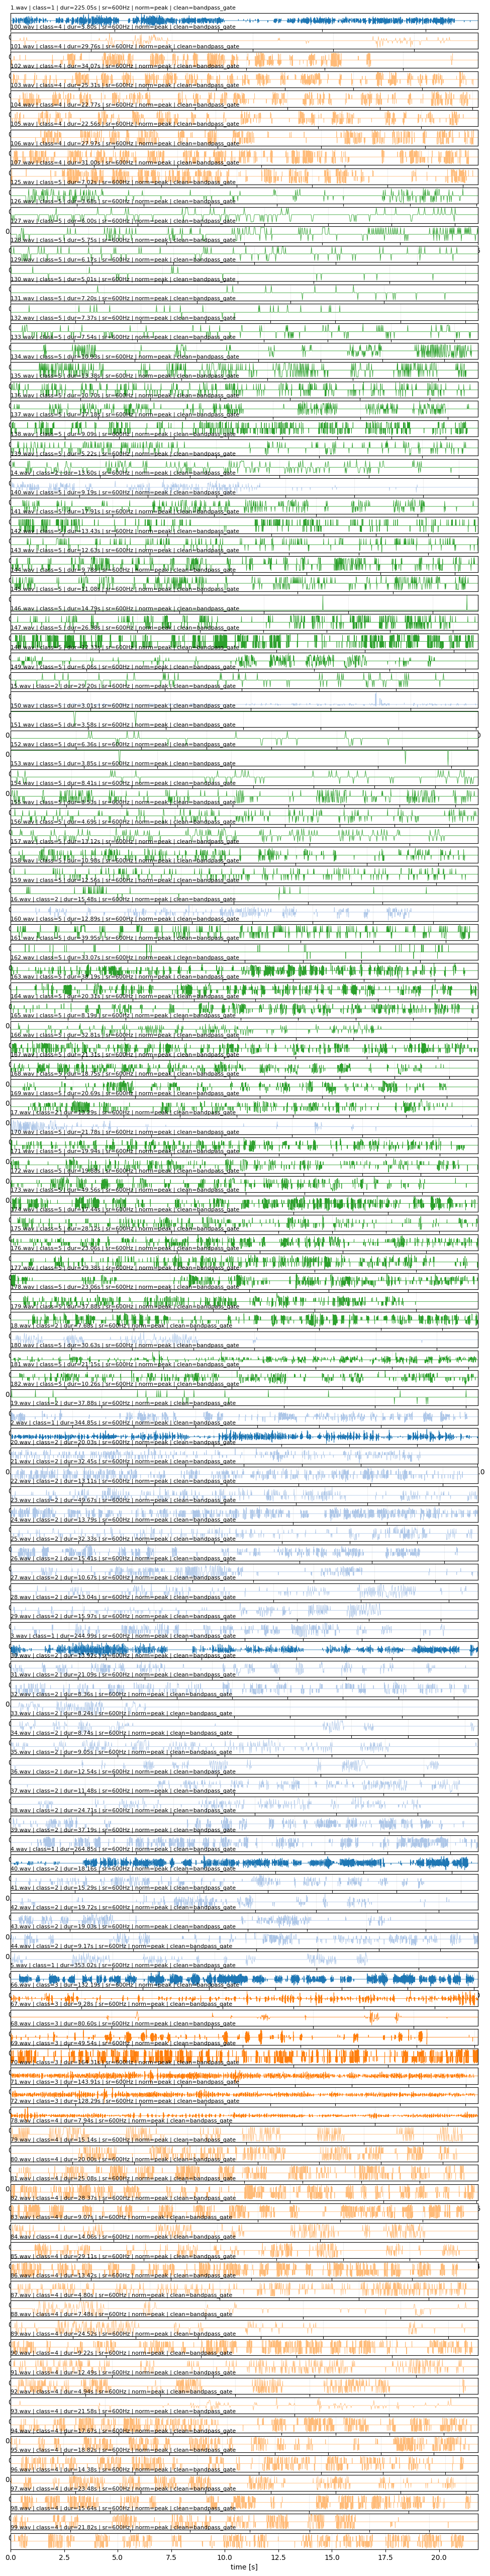

In [70]:
# %pip install -U pandas matplotlib pydub

import os, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pydub import AudioSegment

# -----------------------------
# CONFIG
# -----------------------------
CSV_PATH   = "data/raw/training_label.csv"
AUDIO_DIR  = Path("data/raw/Training_data")
PATTERN    = "*.wav"
MAX_FILES  = None

TARGET_SR  = 16_000     # None = keep original
TARGET_SW  = 2          # bytes per sample; 2 = 16-bit
MAKE_MONO  = True

# Amplitude normalization
NORMALIZE  = "peak"     # "peak", "rms", or None
TARGET_RMS = 0.1        # RMS target in [-1,1]; used if NORMALIZE == "rms"
EPS        = 1e-12

DOWNSAMPLE = 4
SAVE_PNG   = None# %pip install -U pandas matplotlib pydub

import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pydub import AudioSegment, effects as FX

# -----------------------------
# CONFIG
# -----------------------------
CSV_PATH   = "data/raw/training_label.csv"
AUDIO_DIR  = Path("data/raw/Training_data")
PATTERN    = "*.wav"
MAX_FILES  = None

TARGET_SR  = 600     # None = keep original
TARGET_SW  = 2          # bytes per sample; 2 = 16-bit
MAKE_MONO  = True

# Amplitude normalization
NORMALIZE  = "peak"     # "peak", "rms", or None
TARGET_RMS = 0.1
EPS        = 1e-12

# Noise cleaning
CLEAN_MODE   = "bandpass_gate"  # "none", "bandpass", "gate", "bandpass_gate"
HPF_CUTOFF   = 100              # Hz, remove rumble
LPF_CUTOFF   = 6000             # Hz, tame hiss
GATE_K       = 1.5              # threshold = GATE_K * RMS; larger => stronger gate

DOWNSAMPLE = 4
SAVE_PNG   = None

# -----------------------------
# HELPERS
# -----------------------------
def clean_segment(seg: AudioSegment) -> AudioSegment:
    if CLEAN_MODE in ("bandpass", "bandpass_gate"):
        if HPF_CUTOFF is not None:
            seg = FX.high_pass_filter(seg, HPF_CUTOFF)
        if LPF_CUTOFF is not None:
            seg = FX.low_pass_filter(seg, LPF_CUTOFF)
    return seg

def seg_to_mono_np(seg: AudioSegment) -> tuple[np.ndarray, float]:
    sw = seg.sample_width
    sr = float(seg.frame_rate)
    if MAKE_MONO and seg.channels != 1: seg = seg.set_channels(1)
    if TARGET_SR is not None and seg.frame_rate != TARGET_SR:
        seg = seg.set_frame_rate(TARGET_SR); sr = float(TARGET_SR)
    if TARGET_SW is not None and seg.sample_width != TARGET_SW:
        seg = seg.set_sample_width(TARGET_SW); sw = TARGET_SW
    arr = np.array(seg.get_array_of_samples())
    peak = float(1 << (8 * sw - 1))
    y = arr.astype(np.float32) / peak
    return y, sr

def normalize(y: np.ndarray, mode: str | None) -> np.ndarray:
    if mode is None: return y
    if mode == "peak":
        m = np.max(np.abs(y)) + EPS
        return y / m
    if mode == "rms":
        rms = np.sqrt(np.mean(y**2) + EPS)
        return np.clip(y * (TARGET_RMS / rms), -1.0, 1.0)
    raise ValueError

def gate(y: np.ndarray, k: float) -> np.ndarray:
    rms = np.sqrt(np.mean(y**2) + EPS)
    thr = k * rms
    y2 = y.copy()
    y2[np.abs(y2) < thr] = 0.0
    return y2

# -----------------------------
# LOAD LABELS AND MATCH FILES
# -----------------------------
labels = pd.read_csv(CSV_PATH)
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str)

files = sorted(glob.glob(str(AUDIO_DIR / PATTERN)))
df = pd.DataFrame({"path": files, "nombre_archivo": [Path(f).name for f in files]})
df = df.merge(labels[["nombre_archivo", "clase"]], on="nombre_archivo", how="inner")
if MAX_FILES is not None: df = df.iloc[:MAX_FILES].copy()
n = len(df); assert n > 0, "No matching labeled WAV files found."

# -----------------------------
# COLORS
# -----------------------------
classes = sorted(df["clase"].unique())
palette = plt.get_cmap("tab20").colors
color_map = {c: palette[i % len(palette)] for i, c in enumerate(classes)}

# -----------------------------
# PLOT
# -----------------------------
row_h = 0.5
fig_h = max(3, row_h * n)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, fig_h), sharex=False)
if n == 1: axes = [axes]

for ax, (p, fname, cls) in zip(axes, df[["path", "nombre_archivo", "clase"]].itertuples(index=False, name=None)):
    seg = AudioSegment.from_file(p)
    seg = clean_segment(seg)
    y, sr = seg_to_mono_np(seg)
    if CLEAN_MODE in ("gate", "bandpass_gate"):
        y = gate(y, GATE_K)
    y = normalize(y, NORMALIZE)

    if DOWNSAMPLE and DOWNSAMPLE > 1:
        y = y[::DOWNSAMPLE]; sr_eff = sr / DOWNSAMPLE
    else:
        sr_eff = sr
    t = np.arange(len(y)) / sr_eff if len(y) else np.array([0.0])

    ax.plot(t, y, linewidth=0.6, color=color_map[cls])
    ax.set_title(
        f"{fname} | class={cls} | dur={len(seg)/1000:.2f}s | sr={int(sr)}Hz | "
        f"norm={NORMALIZE} | clean={CLEAN_MODE}", fontsize=8, loc="left"
    )
    ax.set_yticks([]); ax.grid(True, alpha=0.2); ax.set_xlim(0, t[-1] if len(t) else 0)

axes[-1].set_xlabel("time [s]")
axes[0].legend([Line2D([0],[0], color=color_map[c], lw=2, label=f"class {c}") for c in classes],
               ncols=min(len(classes), 6), fontsize=8, loc="upper right", frameon=True)
plt.tight_layout()
if SAVE_PNG:
    Path(SAVE_PNG).parent.mkdir(parents=True, exist_ok=True); plt.savefig(SAVE_PNG, dpi=200)
plt.show()


# -----------------------------
# HELPERS
# -----------------------------
def seg_to_mono_np(seg: AudioSegment) -> tuple[np.ndarray, float]:
    sw = seg.sample_width
    sr = float(seg.frame_rate)
    if MAKE_MONO and seg.channels != 1:
        seg = seg.set_channels(1)
    if TARGET_SR is not None and seg.frame_rate != TARGET_SR:
        seg = seg.set_frame_rate(TARGET_SR)
        sr = float(TARGET_SR)
    if TARGET_SW is not None and seg.sample_width != TARGET_SW:
        seg = seg.set_sample_width(TARGET_SW)
        sw = TARGET_SW

    arr = np.array(seg.get_array_of_samples())
    peak = float(1 << (8 * sw - 1))  # signed peak
    y = arr.astype(np.float32) / peak
    return y, sr

def normalize(y: np.ndarray, mode: str | None) -> np.ndarray:
    if mode is None:
        return y
    if mode == "peak":
        m = np.max(np.abs(y)) + EPS
        return y / m
    if mode == "rms":
        rms = np.sqrt(np.mean(y**2) + EPS)
        scale = TARGET_RMS / rms
        return np.clip(y * scale, -1.0, 1.0)
    raise ValueError("NORMALIZE must be 'peak', 'rms', or None")

# -----------------------------
# LOAD LABELS AND MATCH FILES
# -----------------------------
labels = pd.read_csv(CSV_PATH)
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str)

files = sorted(glob.glob(str(AUDIO_DIR / PATTERN)))
df = pd.DataFrame({"path": files, "nombre_archivo": [Path(f).name for f in files]})
df = df.merge(labels[["nombre_archivo", "clase"]], on="nombre_archivo", how="inner")
if MAX_FILES is not None:
    df = df.iloc[:MAX_FILES].copy()

n = len(df)
assert n > 0, "No matching labeled WAV files found."

# -----------------------------
# COLORS PER CLASS
# -----------------------------
classes = sorted(df["clase"].unique())
palette = plt.get_cmap("tab20").colors
color_map = {c: palette[i % len(palette)] for i, c in enumerate(classes)}

# -----------------------------
# PLOT
# -----------------------------
row_h = 0.5
fig_h = max(3, row_h * n)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, fig_h), sharex=False)
if n == 1:
    axes = [axes]

for ax, (p, fname, cls) in zip(axes, df[["path", "nombre_archivo", "clase"]].itertuples(index=False, name=None)):
    seg = AudioSegment.from_file(p)
    y, sr = seg_to_mono_np(seg)
    y = normalize(y, NORMALIZE)
    if DOWNSAMPLE and DOWNSAMPLE > 1:
        y = y[::DOWNSAMPLE]
        sr_eff = sr / DOWNSAMPLE
    else:
        sr_eff = sr
    t = np.arange(len(y)) / sr_eff if len(y) else np.array([0.0])

    ax.plot(t, y, linewidth=0.6, color=color_map[cls])
    ax.set_title(f"{fname} | class={cls} | dur={len(seg)/1000:.2f}s | sr={int(sr)}Hz | norm={NORMALIZE}", fontsize=8, loc="left")
    ax.set_yticks([])
    ax.grid(True, alpha=0.2)
    ax.set_xlim(0, t[-1] if len(t) else 0)

axes[-1].set_xlabel("time [s]")
legend_elems = [Line2D([0],[0], color=color_map[c], lw=2, label=f"class {c}") for c in classes]
axes[0].legend(handles=legend_elems, ncols=min(len(classes), 6), fontsize=8, loc="upper right", frameon=True)

plt.tight_layout()
if SAVE_PNG:
    Path(SAVE_PNG).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(SAVE_PNG, dpi=200)
plt.show()
